In [1]:
# The data referenced here have been saved after extraction and condensing in individual files.
# This has been done to preserve data security of the source data, which may contain sensitive
# personally identifiable information.  Please contact Nathan Hui at nthui@eng.ucsd.edu for
# access to the source data

In [4]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import folium
import utm
import pandas as pd
import math

Mean distance: 3071 m
Median distance: 2800 m
Max distance: 19300 m
Min distance: 100 m


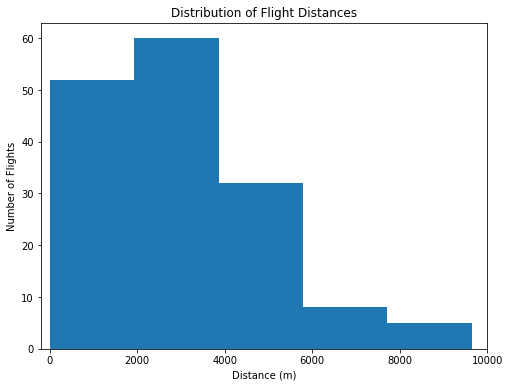

In [8]:
# Plot distance histogram
# distances.npy is generated by distance.py
distances = np.load('distances.npy')
fig = plt.figure(figsize=(8,6))
plt.hist(distances)
plt.xlabel('Distance (m)')
plt.xlim(-200, 10000)
plt.ylabel('Number of Flights')
plt.title('Distribution of Flight Distances')
mean = np.mean(distances)
median = np.median(distances)
max_d = np.max(distances)
min_d = np.min(distances[np.nonzero(distances)])

print('Mean distance: %.0f m' % (mean))
print('Median distance: %.0f m' % (median))
print('Max distance: %.0f m' % (max_d))
print('Min distance: %.0f m' % (min_d))
plt.savefig('outputs/distances.png')

In [13]:
def check_overlap(rect1, rect2):
    '''Checks if the specified rectangles overlap'''
    assert(isinstance(rect1, np.ndarray))
    assert(isinstance(rect2, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(rect2.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    assert(np.issubdtype(rect2.dtype, np.number))

    r1_min = np.amin(rect1, 0)
    r1_max = np.amax(rect1, 0)
    r2_min = np.amin(rect2, 0)
    r2_max = np.amax(rect2, 0)

    if r1_min[0] > r2_max[0] or r2_min[0] > r1_max[0]:
        return False
    if r1_min[1] > r2_max[1] or r2_min[1] > r2_max[1]:
        return False
    return True

def combine_area(rect1, rect2):
    ''' Combines the two rectangles to max extents'''
    assert(isinstance(rect1, np.ndarray))
    assert(isinstance(rect2, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(rect2.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    assert(np.issubdtype(rect2.dtype, np.number))

    r1_min = np.amin(rect1, 0)
    r1_max = np.amax(rect1, 0)
    r2_min = np.amin(rect2, 0)
    r2_max = np.amax(rect2, 0)

    gb_min = np.amin([r1_min, r2_min], 0)
    gb_max = np.amax([r1_max, r2_max], 0)
    return np.array([gb_min,
                    [gb_min[0], gb_max[1]],
                    gb_max,
                    [gb_max[0], gb_min[1]]])

def reorder_extent(rect1):
    ''' Sorts extent corners into clockwise direction'''
    assert(isinstance(rect1, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    r1_min = np.amin(rect1, 0)
    r1_max = np.amax(rect1, 0)
    return np.array([r1_min,
                    [r1_min[0], r1_max[1]],
                    r1_max,
                    [r1_max[0], r1_min[1]]])

def distance_between_ll(rect1, rect2):
    '''Returns the minimum distance in meters between two nonoverlapping areas'''
    assert(isinstance(rect1, np.ndarray))
    assert(isinstance(rect2, np.ndarray))
    assert(rect1.shape == (4, 2))
    assert(rect2.shape == (4, 2))
    assert(np.issubdtype(rect1.dtype, np.number))
    assert(np.issubdtype(rect2.dtype, np.number))
    assert(not check_overlap(rect1, rect2))
    r1 = utm.from_latlon(rect1[0, 0], rect1[0, 1])
    r2 = utm.from_latlon(rect2[0, 0], rect2[0, 1])
    if r1[2] != r2[2] or r1[3] != r2[3]:
        return 9e9
    r1 = np.array([utm.from_latlon(rect1[i, 0], rect1[i, 1])[0:2] for i in range(len(rect1))])
    r2 = np.array([utm.from_latlon(rect2[i, 0], rect2[i, 1])[0:2] for i in range(len(rect1))])
    return distance_between(r1, r2)

def distance_between(r1, r2):
    assert(isinstance(r1, np.ndarray))
    assert(isinstance(r2, np.ndarray))
    assert(r1.shape == (4, 2))
    assert(r2.shape == (4, 2))
    assert(np.issubdtype(r1.dtype, np.number))
    assert(np.issubdtype(r2.dtype, np.number))
    
    
    r1_min = np.amin(r1, axis=0)
    r1_max = np.amax(r1, axis=0)
    r2_min = np.amin(r2, axis=0)
    r2_max = np.amax(r2, axis=0)
    
    if (r2_min[0] > r1_min[0] and r2_min[0] < r1_max[0]) or (r2_max[0] > r1_min[0] and r2_max[0] < r1_max[0]):
        # check min vert
        return np.min([r2_min[0] - r1_max[0], r1_min[0] - r2_max[0]])
    elif (r2_min[1] > r1_min[1] and r2_min[1] < r1_max[1]) or (r2_max[1] > r1_min[1] and r2_max[1] < r1_max[1]):
        return np.min([r2_min[1] - r1_min[1], r1_min[1] - r2_max[1]])
    else:
        return np.min([np.linalg.norm(r1_min - r2_max), np.linalg.norm(r2_min - r1_max),
                      np.linalg.norm(np.array([r1_min[0], r1_max[1]]) - np.array([r2_max[0], r2_min[1]])),
                      np.linalg.norm(np.array([r2_min[0], r2_max[1]]) - np.array([r1_max[0], r1_min[1]]))])

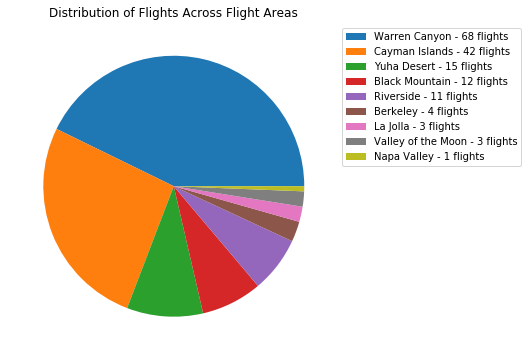

In [37]:
# Plot flight areas
# flight_extents.npy is generated by plot_flight_extents.py
all_extents_orig = np.load('flight_extents.npy')
all_extents = np.array([reorder_extent(extent) for extent in all_extents_orig])
flight_area_extents = []
MIN_DIST_AREA = 500

while True:
    num_extents = len(all_extents)
    while len(all_extents) > 0:
        combined = False
        flight_area = all_extents[0]
        combined_areas = [0]
        for i in range(1, len(all_extents)):
            if check_overlap(flight_area, all_extents[i]):
                flight_area = combine_area(flight_area, all_extents[i])
                combined_areas.append(i)
                combined = True
            elif distance_between_ll(flight_area, all_extents[i]) < MIN_DIST_AREA:
                flight_area = combine_area(flight_area, all_extents[i])
                combined_areas.append(i)
                combined = True
        flight_area_extents.append(flight_area)
        all_extents = [all_extents[i] for i in range(len(all_extents)) if i not in combined_areas]
    if len(flight_area_extents) == num_extents:
        break
    else:
        all_extents = flight_area_extents
        flight_area_extents = []
flight_area_extents = sorted(flight_area_extents, key=lambda x: x[0][1])

flight_area_stats = [0] * len(flight_area_extents)
for flight in all_extents_orig:
    for i in range(len(flight_area_extents)):
        if check_overlap(flight, flight_area_extents[i]) == True:
            flight_area_stats[i] += 1
            break

flight_areas = [np.mean(flight_area_extent, axis=0) for flight_area_extent in flight_area_extents]

folium_map = folium.Map(location=np.mean(np.array(flight_areas), axis=0).tolist(),
                        zoom_start=4,
                        tiles="CartoDB positron")
locations=['Berkeley', 'Napa Valley', 'Riverside', 'Warren Canyon', 'La Jolla', 'Black Mountain', 'Valley of the Moon', 'Yuha Desert', 'Cayman Islands']
# locations=['Black Mountain', 'Cayman Islands', 'La Jolla', 'Napa Valley', 'Valley of the Moon', 'Warren Canyon', 'Yuha Desert','Riverside', 'Berkeley']
# locations=list(range(len(flight_areas)))


for i in range(len(flight_areas)):
    marker = folium.Marker(location=[flight_areas[i][0], flight_areas[i][1]], tooltip=locations[i] )
    marker.add_to(folium_map)
    extent = folium.Polygon(locations=flight_area_extents[i].tolist())
    extent.add_to(folium_map)
folium_map.save('extents.html')

flight_area_stats, locations = zip(*sorted(zip(flight_area_stats, locations), key=lambda x: x[0], reverse=True))
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0]
fig = plt.figure(figsize=(8,6))
patches, texts = plt.pie(flight_area_stats, explode=explode, pctdistance=0.8, radius=1)
patches, labels, dummy =  zip(*sorted(zip(patches, ['%s - %d flights' % (locations[i], flight_area_stats[i]) for i in range(len(flight_area_stats))], flight_area_stats),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels,bbox_to_anchor=(1, 1.))
plt.title('Distribution of Flights Across Flight Areas')
plt.savefig('outputs/areas.png')

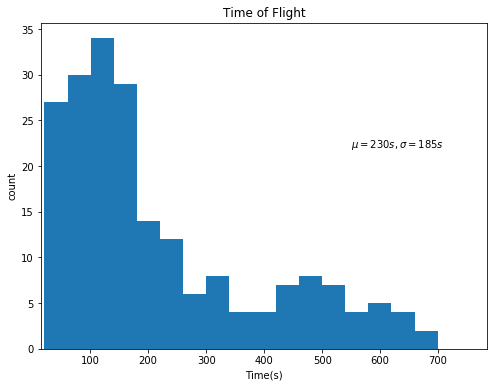

In [10]:
# Plot distribution of flight times
# dates.pkl comes from the data_analysis_kazim.py script
df = pd.read_pickle('dates.pkl')
df = df[['Flight Date','Flight Durations']]
df = df[~df['Flight Date'].isnull()]
df = df.groupby('Flight Date').agg(sum)
df['Flight Durations'] = df['Flight Durations'].apply(lambda x: sorted(x))
list_of_all_durations = []
for i in range(0,len(df['Flight Durations'])):
    old_list = df['Flight Durations'][i]
    new_list = [x for x in old_list if x>20]
    list_of_all_durations.extend(new_list)
bins = np.linspace(math.ceil(min(list_of_all_durations)),math.floor(max(list_of_all_durations)),20) # fixed number of bins

fig = plt.figure(figsize=(8, 6))
plt.xlim([min(list_of_all_durations)-5, max(list_of_all_durations)+5])

plt.hist(list_of_all_durations, bins=bins)
# plt.grid(axis='y')
plt.title('Time of Flight')
plt.text(550, 22, r'$\mu = 230 s, \sigma = 185 s$')
plt.xlabel('Time(s)')
plt.ylabel('count')
plt.savefig('outputs/flight_times.png')